# Aria Synthetic Environments (ASE) Dataset Exploration

This notebook provides a comprehensive exploration of the ASE dataset, covering all available modalities and tools from `projectaria_tools`.

## Dataset Overview

The ASE dataset provides:
- **100K synthetic indoor scenes**
- **RGB images** (egocentric trajectory)
- **Depth maps** (ground truth)
- **Instance segmentation masks**
- **6DoF camera trajectories**
- **Semi-dense point clouds** (from MPS SLAM)
- **SceneScript language annotations** (walls, doors, windows)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pathlib import Path
from PIL import Image
import json

# ProjectAria Tools
from projectaria_tools.projects.ase import readers
from projectaria_tools.projects import ase
from projectaria_tools.core import mps
from projectaria_tools.core.sophus import SE3

## Setup: Choose a Scene

In [ ]:
ROOT_DIR = Path.cwd().parent.resolve()
SCENE_PATH = ROOT_DIR / ".data/semidense_samples/ase/ase_examples/0"

assert SCENE_PATH.exists(), f"Scene path not found: {SCENE_PATH}"

print(f"Using scene: {SCENE_PATH}")
print(f"\nScene directory structure:")
for item in sorted(SCENE_PATH.iterdir()):
    if item.is_file():
        size_mb = item.stat().st_size / (1024 * 1024)
        print(f"  {item.name}: {size_mb:.2f} MB")
    else:
        num_files = len(list(item.glob('*')))
        print(f"  {item.name}/: {num_files} files")

Using scene: /home/jandu/repos/NBV/.data/semidense_samples/ase/ase_examples/0

Scene directory structure:
  ase_scene_language.txt: 0.00 MB
  depth/: 350 files
  instances/: 350 files
  object_instances_to_classes.json: 0.00 MB
  rgb/: 350 files
  semidense_observations.csv.gz: 24.37 MB
  semidense_points.csv.gz: 10.11 MB
  trajectory.csv: 0.05 MB


# Part 1: Scene Language and Annotations

## Loading SceneScript Ground Truth

In [3]:
# Load scene language using projectaria_tools
language_path = SCENE_PATH / "ase_scene_language.txt"
scene_entities = readers.read_language_file(language_path)

print(f"Total entities: {len(scene_entities)}\n")

# Analyze entity types
from collections import Counter
entity_counts = Counter([cmd for cmd, params in scene_entities])
print("Entity distribution:")
for entity_type, count in entity_counts.items():
    print(f"  {entity_type}: {count}")

# Show first few entities
print("\nFirst 3 entities:")
for i, (cmd, params) in enumerate(scene_entities[:3]):
    print(f"\n{i+1}. {cmd}:")
    for key, value in params.items():
        print(f"    {key}: {value}")

Loaded scene commands with a total of 15 entities.
Total entities: 15

Entity distribution:
  make_wall: 8
  make_door: 3
  make_window: 4

First 3 entities:

1. make_wall:
    id: 0.0
    a_x: -2.5652206130325794
    a_y: 6.1646646447479725
    a_z: 0.0
    b_x: 5.069175712764263
    b_y: 6.1646646447479725
    b_z: 0.0
    height: 3.262429714202881
    thickness: 0.0

2. make_wall:
    id: 1.0
    a_x: 5.069175712764263
    a_y: 6.1646646447479725
    a_z: 0.0
    b_x: 5.069175712764263
    b_y: 1.9122125282883644
    b_z: 0.0
    height: 3.262429714202881
    thickness: 0.0

3. make_wall:
    id: 2.0
    a_x: 5.069175712764263
    a_y: 1.9122125282883644
    a_z: 0.0
    b_x: -2.5652206130325794
    b_y: 1.9122125282883644
    b_z: 0.0
    height: 3.262429714202881
    thickness: 0.0


## Converting Language to 3D Bounding Boxes

In [4]:
# Convert entities to bboxes for visualization
from projectaria_tools.projects.ase.interpreter import language_to_bboxes

entity_boxes = language_to_bboxes(scene_entities)

print(f"\nConverted {len(entity_boxes)} entities to 3D boxes")
print("\nExample box:")
box = entity_boxes[0]
print(f"  Class: {box['class']}")
print(f"  Center: {box['center']}")
print(f"  Scale: {box['scale']}")
print(f"  Rotation:\n{box['rotation']}")

Scene contains:
  wall: 8
  door: 3
  window: 4

Converted 15 entities to 3D boxes

Example box:
  Class: wall
  Center: [1.25197755 6.16466464 1.63121486]
  Scale: [7.63439633 0.         3.26242971]
  Rotation:
[[ 1. -0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


## Instance-to-Class Mapping

In [5]:
# Load instance mapping
mapping_path = SCENE_PATH / "object_instances_to_classes.json"
with open(mapping_path, 'r') as f:
    instance_to_class = json.load(f)

print(f"Total instance IDs: {len(instance_to_class)}\n")

# Count classes
class_counts = Counter(instance_to_class.values())
print("Top 15 object classes:")
for class_name, count in class_counts.most_common(15):
    print(f"  {class_name}: {count}")

# Show some mappings
print("\nExample instance mappings:")
for inst_id, class_name in list(instance_to_class.items())[:10]:
    print(f"  Instance {inst_id}: {class_name}")

Total instance IDs: 119

Top 15 object classes:
  door: 17
  picture_frame_or_painting: 14
  chair: 12
  table: 12
  wall: 8
  plant_or_flower_pot: 8
  bed: 6
  window: 4
  cabinet: 4
  container_or_basket: 4
  lamp: 4
  mirror: 4
  ceiling: 2
  floor: 2
  clothes_rack: 2

Example instance mappings:
  Instance 0: empty_space
  Instance 1: background
  Instance 2: wall
  Instance 3: wall
  Instance 4: wall
  Instance 5: ceiling
  Instance 6: floor
  Instance 7: wall
  Instance 8: wall
  Instance 9: wall


# Part 2: Trajectory and Camera Poses

## Loading 6DoF Trajectory

In [6]:
# Load trajectory
trajectory_path = SCENE_PATH / "trajectory.csv"
trajectory = readers.read_trajectory_file(trajectory_path)

Ts_world_device = trajectory['Ts_world_from_device']
timestamps = trajectory['timestamps']

print(f"Trajectory length: {len(Ts_world_device)} poses")
print(f"Duration: {(timestamps[-1] - timestamps[0]) / 1e6:.2f} seconds")
print(f"Framerate: {len(timestamps) / ((timestamps[-1] - timestamps[0]) / 1e6):.2f} fps")

# Extract positions and orientations - convert SE3 to matrices
positions = np.array([T.to_matrix()[:3, 3] for T in Ts_world_device])
print(f"\nTrajectory extent:")
print(f"  X: [{positions[:,0].min():.2f}, {positions[:,0].max():.2f}] m")
print(f"  Y: [{positions[:,1].min():.2f}, {positions[:,1].max():.2f}] m")
print(f"  Z: [{positions[:,2].min():.2f}, {positions[:,2].max():.2f}] m")

# Calculate trajectory distance
distances = np.linalg.norm(np.diff(positions, axis=0), axis=1)
total_distance = distances.sum()
print(f"\nTotal trajectory distance: {total_distance:.2f} m")


Loaded trajectory with 350 device poses.
Trajectory length: 350 poses
Duration: 34.90 seconds
Framerate: 10.03 fps

Trajectory extent:
  X: [-1.94, 4.91] m
  Y: [-3.26, 5.69] m
  Z: [1.23, 1.76] m

Total trajectory distance: 46.34 m


## Visualizing Trajectory Path

In [7]:
# Plot trajectory in 3D
fig = go.Figure()

# Add trajectory line
fig.add_trace(go.Scatter3d(
    x=positions[:, 0],
    y=positions[:, 1],
    z=positions[:, 2],
    mode='lines+markers',
    name='Camera Trajectory',
    line=dict(color='red', width=3),
    marker=dict(size=2)
))

# Mark start and end
fig.add_trace(go.Scatter3d(
    x=[positions[0, 0]], y=[positions[0, 1]], z=[positions[0, 2]],
    mode='markers',
    name='Start',
    marker=dict(size=10, color='green')
))
fig.add_trace(go.Scatter3d(
    x=[positions[-1, 0]], y=[positions[-1, 1]], z=[positions[-1, 2]],
    mode='markers',
    name='End',
    marker=dict(size=10, color='blue')
))

fig.update_layout(
    title='Egocentric Camera Trajectory',
    scene=dict(aspectmode='data'),
    width=900, height=600
)
fig.show()

## Camera Calibration

In [8]:
# Get ASE RGB camera calibration
camera_calib = ase.get_ase_rgb_calibration()

print("Camera Calibration:")
print(f"  Image size: {camera_calib.get_image_size()}")
print(f"  Focal length: {camera_calib.get_focal_lengths()}")
print(f"  Principal point: {camera_calib.get_principal_point()}")
print(f"\nDevice-to-Camera Transform:")
print(camera_calib.get_transform_device_camera().to_matrix())

Camera Calibration:
  Image size: [704 704]
  Focal length: [297.6375381 297.6375381]
  Principal point: [357.65991972 349.19224971]

Device-to-Camera Transform:
[[ 0.99606003 -0.04388682  0.07706079 -0.0075301 ]
 [ 0.08210934  0.78468796 -0.61442889 -0.01090855]
 [-0.03350334  0.61833547  0.78519983 -0.00359806]
 [ 0.          0.          0.          1.        ]]


# Part 3: Point Clouds

## Loading Semi-Dense Point Cloud

In [9]:
# Load semi-dense points with full metadata
points_path = SCENE_PATH / "semidense_points.csv.gz"
points_df = pd.read_csv(points_path, compression='gzip')

print(f"Semi-Dense Points DataFrame:")
print(points_df.head())
print(f"\nColumns: {list(points_df.columns)}")
print(f"\nTotal points: {len(points_df):,}")

# Extract XYZ coordinates
points = points_df[['px_world', 'py_world', 'pz_world']].values

print(f"\nPoint cloud extent:")
print(f"  X: [{points[:,0].min():.2f}, {points[:,0].max():.2f}] m")
print(f"  Y: [{points[:,1].min():.2f}, {points[:,1].max():.2f}] m")
print(f"  Z: [{points[:,2].min():.2f}, {points[:,2].max():.2f}] m")

# Point density
volume = np.prod(points.max(axis=0) - points.min(axis=0))
density = len(points) / volume
print(f"\nPoint density: {density:.2f} points/m³")

# Uncertainty statistics
print(f"\nUncertainty Statistics:")
print(f"  inv_dist_std: mean={points_df['inv_dist_std'].mean():.6f}, std={points_df['inv_dist_std'].std():.6f}")
print(f"  dist_std: mean={points_df['dist_std'].mean():.6f}, std={points_df['dist_std'].std():.6f}")

Semi-Dense Points DataFrame:
   uid                             graph_uid  px_world  py_world  pz_world  \
0   37  00000000-0000-0000-0000-000000000000  1.512838  3.266084  0.907937   
1   84  00000000-0000-0000-0000-000000000000  2.042020  2.418741  0.493055   
2  118  00000000-0000-0000-0000-000000000000  2.168058  2.486583  0.541335   
3  119  00000000-0000-0000-0000-000000000000  2.557700  1.916963  0.435591   
4  126  00000000-0000-0000-0000-000000000000  2.597028  1.934962  0.497302   

   inv_dist_std  dist_std  
0      0.003901  0.002598  
1      0.004357  0.013965  
2      0.005829  0.017871  
3      0.006255  0.035848  
4      0.006367  0.035745  

Columns: ['uid', 'graph_uid', 'px_world', 'py_world', 'pz_world', 'inv_dist_std', 'dist_std']

Total points: 433,426

Point cloud extent:
  X: [-12.49, 9.05] m
  Y: [-6.08, 8.62] m
  Z: [-5.50, 5.42] m

Point density: 125.41 points/m³

Uncertainty Statistics:
  inv_dist_std: mean=0.002964, std=0.003372
  dist_std: mean=0.010189, st

## Understanding Point Properties

The `semidense_points.csv.gz` file contains:
- **uid**: Unique point identifier
- **graph_uid**: Graph identifier (tracking session)
- **px_world, py_world, pz_world**: 3D coordinates in world frame
- **inv_dist_std**: Inverse distance standard deviation (uncertainty metric)
- **dist_std**: Distance standard deviation (depth uncertainty)

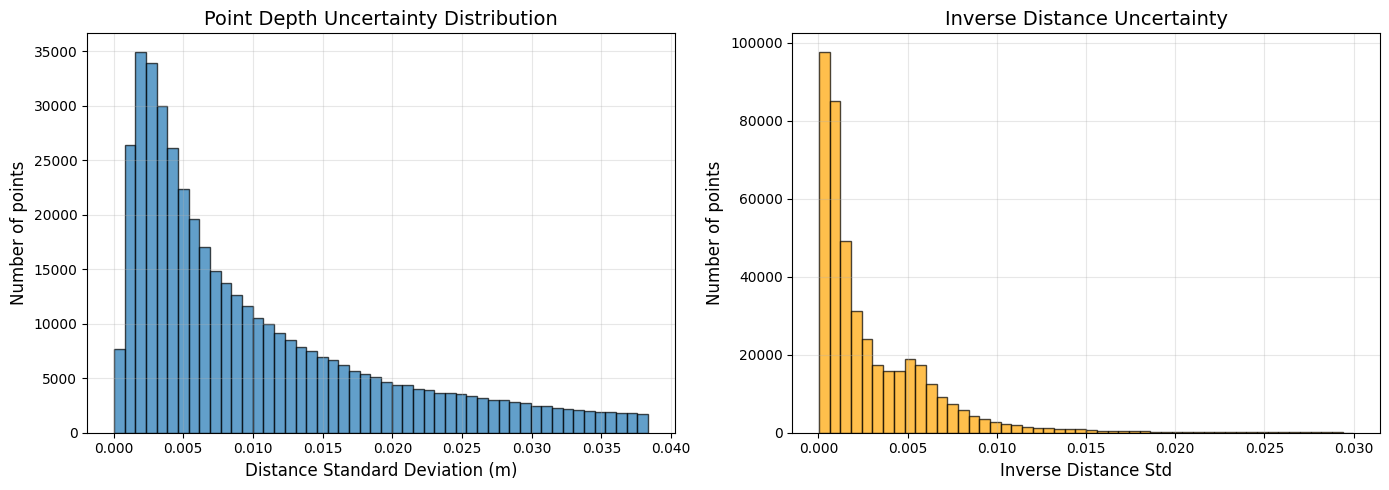

High-confidence points (dist_std < 0.01m): 271,163 (62.6%)
Low-confidence points (dist_std > 0.05m): 0 (0.0%)


In [10]:
# Visualize point uncertainty distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(points_df['dist_std'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Distance Standard Deviation (m)', fontsize=12)
axes[0].set_ylabel('Number of points', fontsize=12)
axes[0].set_title('Point Depth Uncertainty Distribution', fontsize=14)
axes[0].grid(alpha=0.3)

axes[1].hist(points_df['inv_dist_std'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Inverse Distance Std', fontsize=12)
axes[1].set_ylabel('Number of points', fontsize=12)
axes[1].set_title('Inverse Distance Uncertainty', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"High-confidence points (dist_std < 0.01m): {(points_df['dist_std'] < 0.01).sum():,} ({100*(points_df['dist_std'] < 0.01).sum()/len(points_df):.1f}%)")
print(f"Low-confidence points (dist_std > 0.05m): {(points_df['dist_std'] > 0.05).sum():,} ({100*(points_df['dist_std'] > 0.05).sum()/len(points_df):.1f}%)")

## Loading Point Observations (Visibility)

In [11]:
# Load observations - which frames see which points
obs_path = SCENE_PATH / "semidense_observations.csv.gz"
observations_df = pd.read_csv(obs_path, compression='gzip')

print(f"Observations DataFrame:")
print(observations_df.head())
print(f"\nColumns: {list(observations_df.columns)}")
print(f"\nTotal observations: {len(observations_df):,}")

# Map observation UIDs to point UIDs - check if rename is needed
if 'uid' in observations_df.columns and 'point_uid' not in observations_df.columns:
    observations_df = observations_df.rename(columns={'uid': 'point_uid'})

# Statistics
obs_per_point = observations_df.groupby('point_uid').size()
print(f"\nObservations per point:")
print(f"  Mean: {obs_per_point.mean():.2f}")
print(f"  Median: {obs_per_point.median():.0f}")
print(f"  Max: {obs_per_point.max():.0f}")

# Frame statistics
frames_per_point = observations_df.groupby('point_uid')['frame_tracking_timestamp_us'].nunique()
print(f"\nUnique frames per point:")
print(f"  Mean: {frames_per_point.mean():.2f}")
print(f"  Median: {frames_per_point.median():.0f}")


Observations DataFrame:
   uid  frame_tracking_timestamp_us  camera_serial      u     v
0    0                       100000             16  545.0  10.0
1    1                       100000             16  580.0  10.0
2    2                       100000             16  550.0  12.0
3    3                       100000             16  588.0  15.0
4    4                       100000             16  542.0  19.0

Columns: ['uid', 'frame_tracking_timestamp_us', 'camera_serial', 'u', 'v']

Total observations: 2,537,088

Observations per point:
  Mean: 5.15
  Median: 4
  Max: 73

Unique frames per point:
  Mean: 4.45
  Median: 3

Unique frames per point:
  Mean: 4.45
  Median: 3


## Understanding Observations

The `semidense_observations.csv.gz` file contains:
- **point_uid** (originally 'uid'): Links to points in semidense_points.csv.gz
- **frame_tracking_timestamp_us**: Timestamp of frame that observes this point
- **camera_serial**: Camera ID (for multi-camera setups)
- **u, v**: Pixel coordinates where point was observed in that frame

This establishes the **many-to-many relationship**: each point can be seen in multiple frames, and each frame sees multiple points.

## Key Differences: Points vs Observations

| Aspect | semidense_points.csv.gz | semidense_observations.csv.gz |
|--------|-------------------------|-------------------------------|
| **Purpose** | 3D point cloud (SLAM output) | Visibility/tracking data |
| **Rows** | One per 3D point | One per (point, frame) pair |
| **Coordinates** | World 3D (px, py, pz) | Image 2D (u, v) + timestamp |
| **Unique IDs** | ~100K points | ~3-5M observations |
| **Uncertainty** | dist_std, inv_dist_std | None (observation is binary) |
| **Use Case** | 3D reconstruction | View planning, coverage analysis |

## Visualizing Point Cloud with Trajectory

In [12]:
# Subsample points for visualization
subsample_idx = np.random.choice(len(points), min(50000, len(points)), replace=False)
points_vis = points[subsample_idx]

fig = go.Figure()

# Add point cloud
fig.add_trace(go.Scatter3d(
    x=points_vis[:, 0],
    y=points_vis[:, 1],
    z=points_vis[:, 2],
    mode='markers',
    name='Semi-Dense Points',
    marker=dict(size=1, color='lightblue', opacity=0.3)
))

# Add trajectory
fig.add_trace(go.Scatter3d(
    x=positions[:, 0],
    y=positions[:, 1],
    z=positions[:, 2],
    mode='lines',
    name='Trajectory',
    line=dict(color='red', width=4)
))

fig.update_layout(
    title='Semi-Dense Point Cloud + Trajectory',
    scene=dict(aspectmode='data'),
    width=1000, height=700
)
fig.show()

# Part 4: RGB, Depth, and Instance Images

## Loading Images

In [13]:
# Choose a random frame
rgb_dir = SCENE_PATH / "rgb"
depth_dir = SCENE_PATH / "depth"
instance_dir = SCENE_PATH / "instances"

num_frames = len(list(rgb_dir.glob("*.jpg")))
frame_idx = np.random.randint(num_frames)
frame_id = str(frame_idx).zfill(7)

print(f"Loading frame {frame_idx} (of {num_frames})")

# Load images
rgb = np.array(Image.open(rgb_dir / f"vignette{frame_id}.jpg"))
depth = np.array(Image.open(depth_dir / f"depth{frame_id}.png"))
instances = np.array(Image.open(instance_dir / f"instance{frame_id}.png"))

print(f"RGB shape: {rgb.shape}")
print(f"Depth shape: {depth.shape}, range: [{depth.min()}, {depth.max()}] mm")
print(f"Instances shape: {instances.shape}, unique IDs: {len(np.unique(instances))}")

Loading frame 223 (of 350)
RGB shape: (704, 704, 3)
Depth shape: (704, 704), range: [1269, 3960] mm
Instances shape: (704, 704), unique IDs: 13


## Visualizing All Modalities

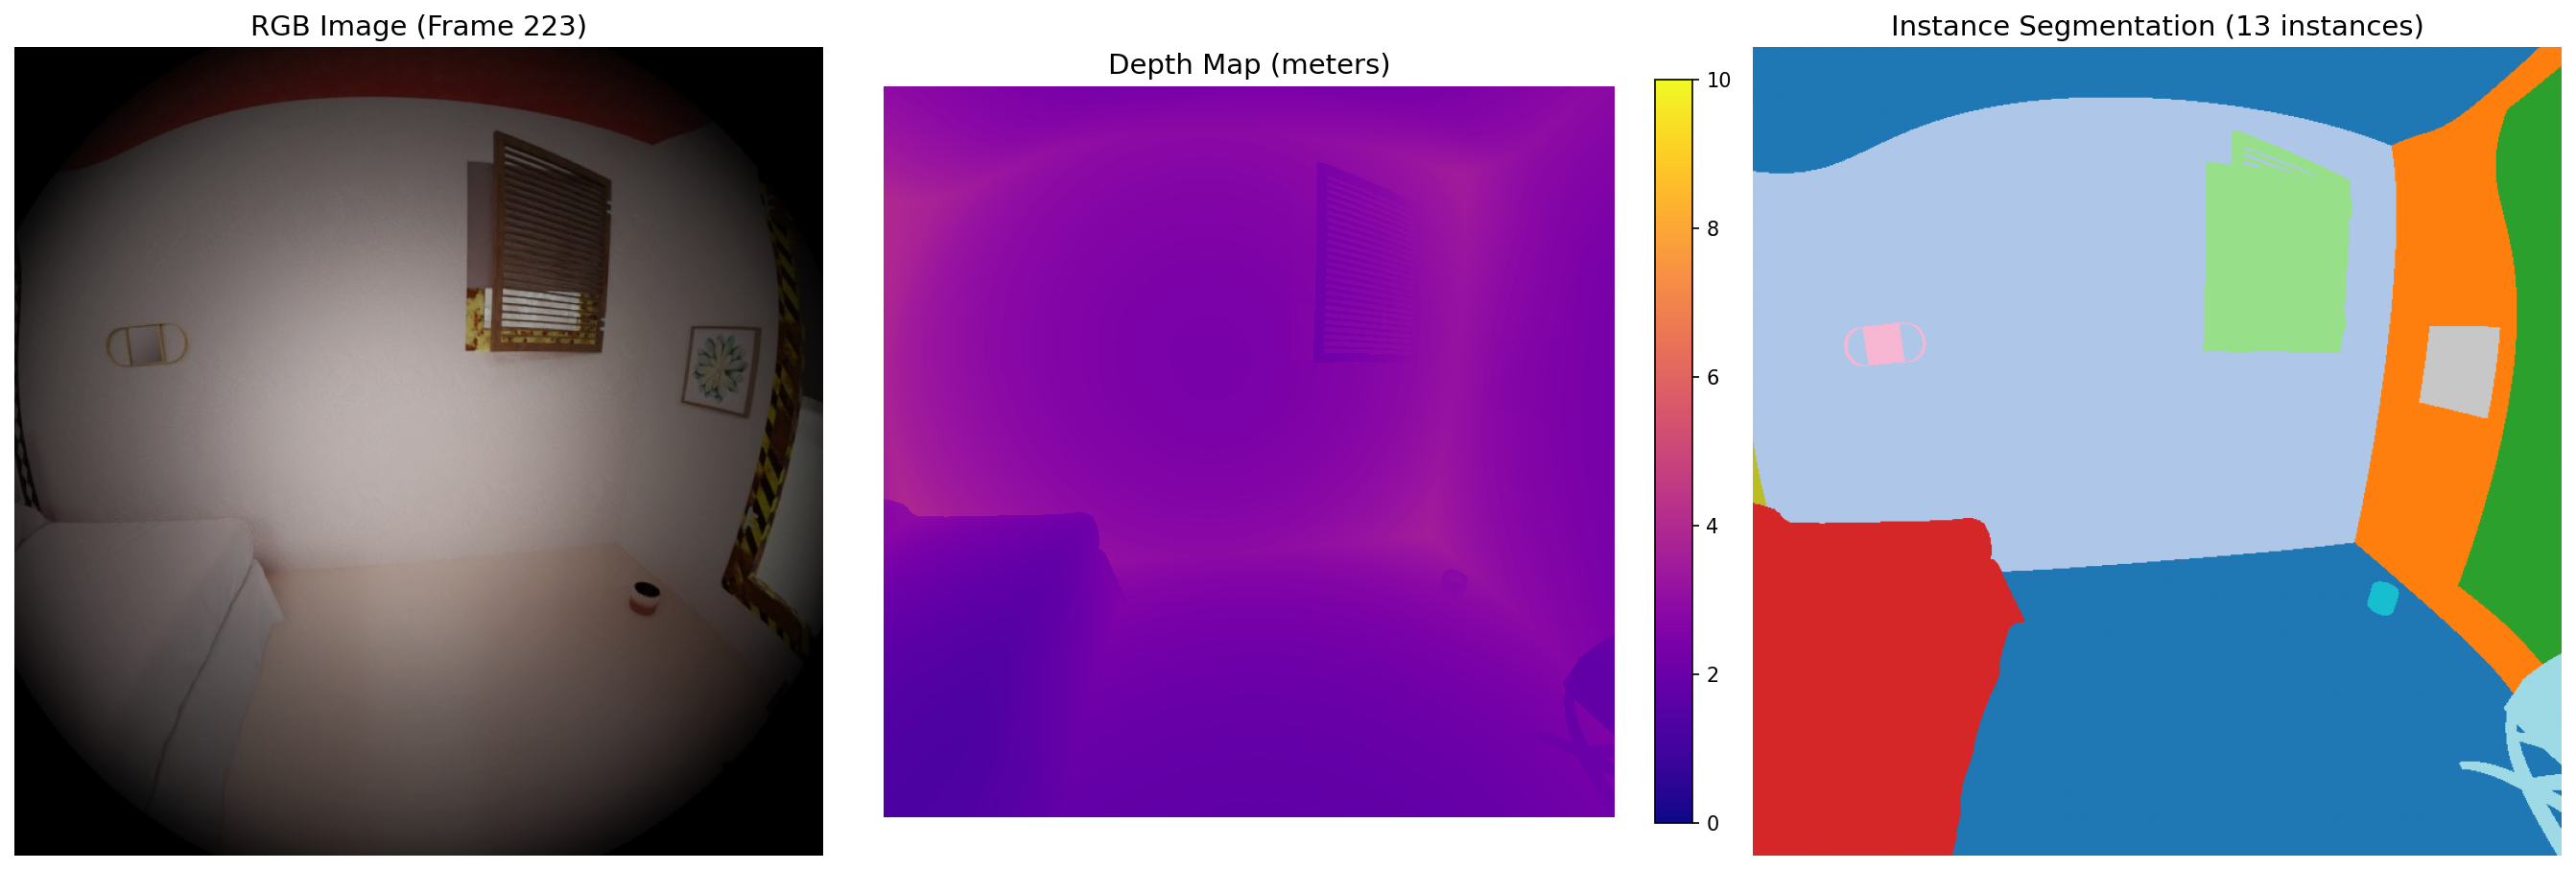

In [14]:
# Rotate images for upright visualization (ASE images are rotated)
from scipy.ndimage import rotate
rgb_rot = np.rot90(rgb, k=-1)
depth_rot = np.rot90(depth, k=-1)
instances_rot = np.rot90(instances, k=-1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=150)

# RGB
axes[0].imshow(rgb_rot)
axes[0].set_title(f'RGB Image (Frame {frame_idx})', fontsize=14)
axes[0].axis('off')

# Depth
depth_m = depth_rot / 1000.0  # Convert mm to meters
im1 = axes[1].imshow(depth_m, cmap='plasma', vmin=0, vmax=10)
axes[1].set_title('Depth Map (meters)', fontsize=14)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# Instances
im2 = axes[2].imshow(instances_rot, cmap='tab20')
axes[2].set_title(f'Instance Segmentation ({len(np.unique(instances))} instances)', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

## Analyzing Instance Segmentation

In [15]:
# Get instance statistics for this frame
unique_instances, instance_counts = np.unique(instances, return_counts=True)

# Map to class names
instance_classes = []
for inst_id in unique_instances:
    class_name = instance_to_class.get(str(inst_id), 'unknown')
    pixels = instance_counts[unique_instances == inst_id][0]
    instance_classes.append((inst_id, class_name, pixels))

# Sort by pixel count
instance_classes.sort(key=lambda x: x[2], reverse=True)

print(f"Visible instances in frame {frame_idx}:")
print(f"\n{'Instance ID':<15} {'Class':<30} {'Pixels':<10} {'% Frame'}")
print("-" * 70)
total_pixels = rgb.shape[0] * rgb.shape[1]
for inst_id, class_name, pixels in instance_classes[:15]:
    pct = 100 * pixels / total_pixels
    print(f"{inst_id:<15} {class_name:<30} {pixels:<10,} {pct:>6.2f}%")

Visible instances in frame 223:

Instance ID     Class                          Pixels     % Frame
----------------------------------------------------------------------
9               wall                           177,087     35.73%
6               floor                          112,821     22.76%
20              bed                            59,348      11.97%
5               ceiling                        43,139       8.70%
10              wall                           41,852       8.44%
15              window                         26,542       5.36%
17              window                         21,051       4.25%
52              table                          5,452        1.10%
42              picture_frame_or_painting      4,561        0.92%
8               wall                           1,485        0.30%
36              mirror                         1,345        0.27%
48              plant_or_flower_pot            625          0.13%
43              picture_frame_or_paint

# Part 5: Coordinate Frame Transformations

## Projecting 3D Points into Images

In [16]:
def transform_points(T, points):
    """Transform 3D points using 4x4 transformation matrix."""
    points_h = np.concatenate([points, np.ones((len(points), 1))], axis=1)
    transformed = (T @ points_h.T).T
    return transformed[:, :3]

# Select a subset of points for projection
proj_idx = np.random.choice(len(points), 1000, replace=False)
points_world = points[proj_idx]

# Get transform for selected frame - convert SE3 to matrix
T_world_from_device = Ts_world_device[frame_idx].to_matrix()
T_device_from_world = np.linalg.inv(T_world_from_device)

# Transform to device frame
points_device = transform_points(T_device_from_world, points_world)

# Transform to camera frame
T_device_from_camera = camera_calib.get_transform_device_camera().to_matrix()
T_camera_from_device = np.linalg.inv(T_device_from_camera)
points_camera = transform_points(T_camera_from_device, points_device)

# Project to image
points_image = []
point_depths = []
for pt in points_camera:
    projected = camera_calib.project(pt)
    if projected is not None:
        points_image.append(projected)
        point_depths.append(pt[2])  # Z coordinate is depth

points_image = np.array(points_image)
point_depths = np.array(point_depths)

print(f"Projected {len(points_image)} / {len(points_world)} points into frame")


Projected 63 / 1000 points into frame


## Visualizing Projected Points

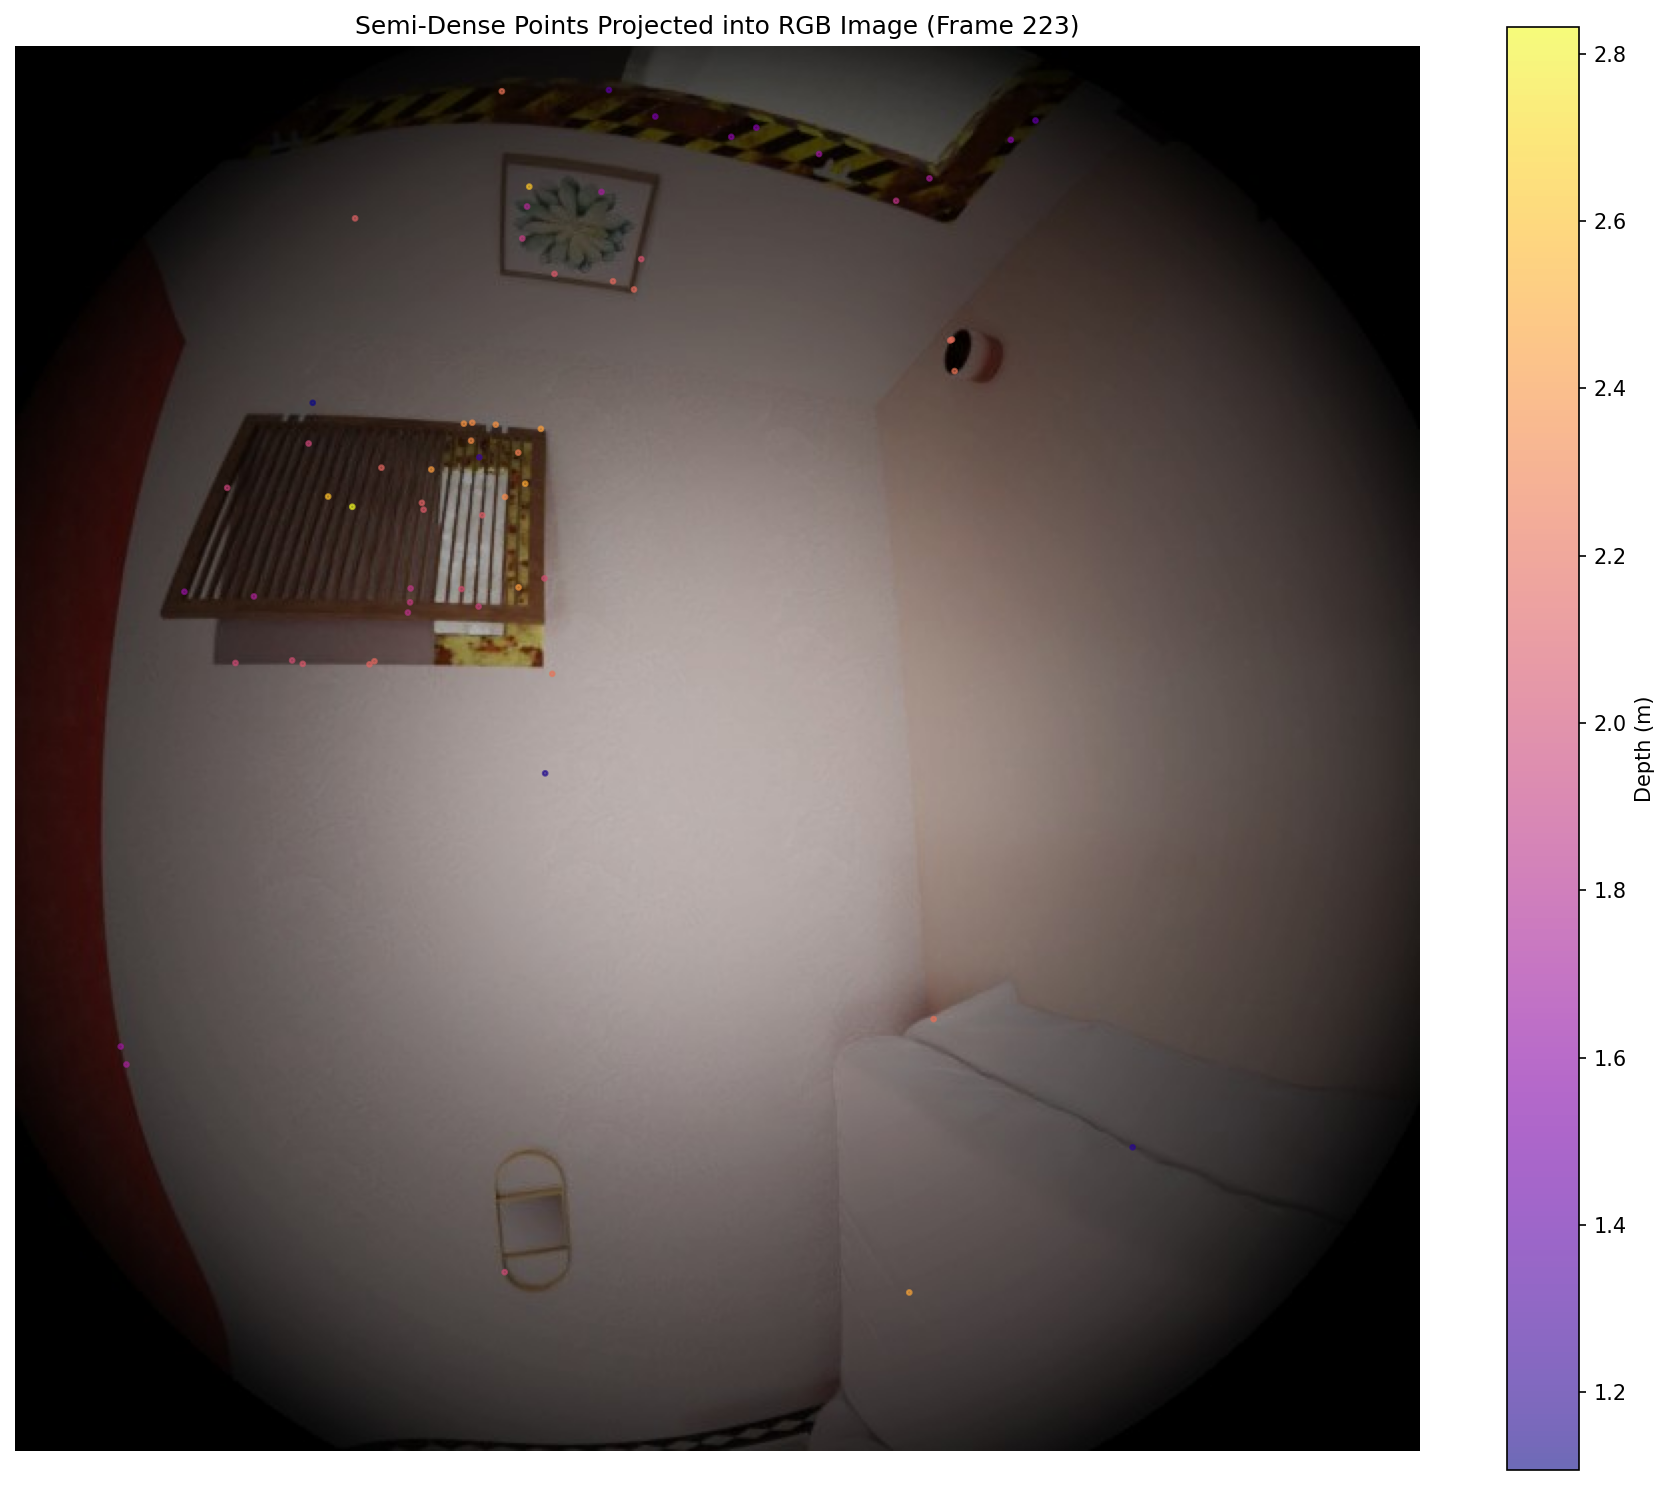

In [17]:
plt.figure(figsize=(12, 10), dpi=150)
plt.imshow(rgb)
plt.scatter(points_image[:, 0], points_image[:, 1],
           c=point_depths, cmap='plasma', s=5, alpha=0.6)
plt.colorbar(label='Depth (m)')
plt.title(f'Semi-Dense Points Projected into RGB Image (Frame {frame_idx})')
plt.axis('off')
plt.tight_layout()
plt.show()

# Part 6: NBV Planning Relevance

## Computing Point Visibility Coverage

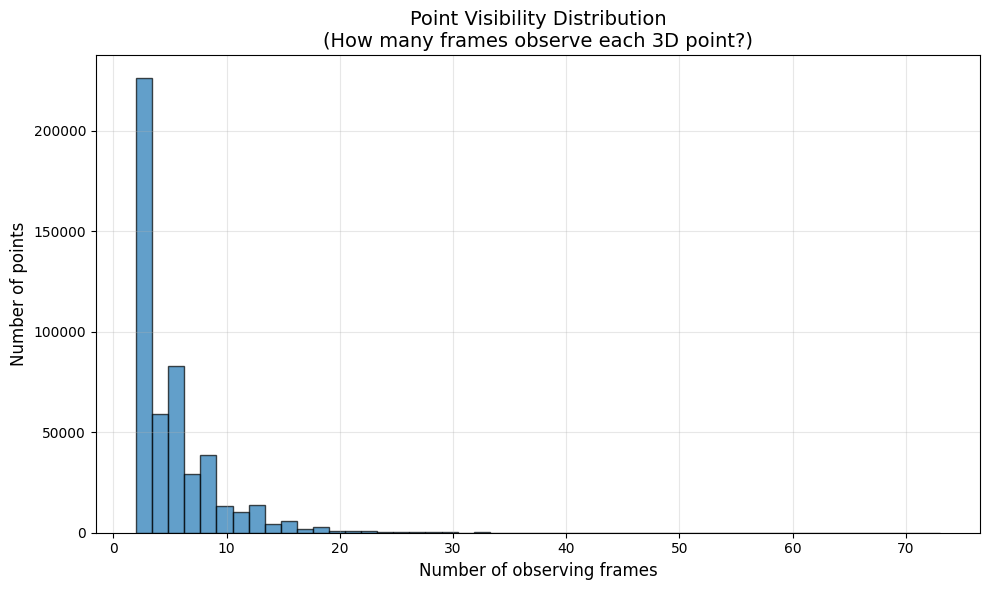

Points observed by:
  1 frame: 0
  2-5 frames: 332,741
  5-10 frames: 116,445
  >10 frames: 43,577


In [18]:
# Analyze which points are visible from how many frames
point_visibility = observations_df.groupby('point_uid').size()

plt.figure(figsize=(10, 6))
plt.hist(point_visibility.values, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of observing frames', fontsize=12)
plt.ylabel('Number of points', fontsize=12)
plt.title('Point Visibility Distribution\n(How many frames observe each 3D point?)', fontsize=14)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Points observed by:")
print(f"  1 frame: {(point_visibility == 1).sum():,}")
print(f"  2-5 frames: {((point_visibility >= 2) & (point_visibility <= 5)).sum():,}")
print(f"  5-10 frames: {((point_visibility > 5) & (point_visibility <= 10)).sum():,}")
print(f"  >10 frames: {(point_visibility > 10).sum():,}")

# Part 7: Advanced Point Cloud Operations

## 7.1 Creating Ground Truth Dense Point Cloud from Depth Images

In [19]:
def depth_to_pointcloud(depth_map, camera_calib, T_world_from_device, subsample=4):
    """
    Convert a depth map to a 3D point cloud in world coordinates.

    Args:
        depth_map: Depth image in mm (H x W)
        camera_calib: Camera calibration object
        T_world_from_device: 4x4 transform matrix or SE3 object from device to world
        subsample: Downsample factor (1=full res, 2=half res, etc.)

    Returns:
        points_world: (N, 3) array of 3D points in world frame
        colors: (N, 3) array of RGB colors (if RGB provided)
    """
    # Convert SE3 to matrix if needed
    if hasattr(T_world_from_device, 'to_matrix'):
        T_world_from_device = T_world_from_device.to_matrix()

    H, W = depth_map.shape

    # Create pixel grid (subsample for efficiency)
    u_coords, v_coords = np.meshgrid(
        np.arange(0, W, subsample),
        np.arange(0, H, subsample)
    )
    u_coords = u_coords.flatten()
    v_coords = v_coords.flatten()

    # Get depths in meters
    depths = depth_map[v_coords, u_coords] / 1000.0  # mm to m

    # Filter invalid depths
    valid_mask = (depths > 0.1) & (depths < 10.0)  # Reasonable depth range
    u_coords = u_coords[valid_mask]
    v_coords = v_coords[valid_mask]
    depths = depths[valid_mask]

    # Unproject pixels to 3D camera frame
    T_device_from_camera = camera_calib.get_transform_device_camera().to_matrix()
    T_camera_from_device = np.linalg.inv(T_device_from_camera)

    points_camera = []
    for u, v, d in zip(u_coords, v_coords, depths):
        # Unproject using camera model
        ray = camera_calib.unproject([u, v])
        if ray is not None:
            # Scale ray by depth
            pt_camera = np.array(ray) * d
            points_camera.append(pt_camera)

    points_camera = np.array(points_camera)

    # Transform to device frame
    points_camera_h = np.concatenate([points_camera, np.ones((len(points_camera), 1))], axis=1)
    points_device = (np.linalg.inv(T_camera_from_device) @ points_camera_h.T).T[:, :3]

    # Transform to world frame
    points_device_h = np.concatenate([points_device, np.ones((len(points_device), 1))], axis=1)
    points_world = (T_world_from_device @ points_device_h.T).T[:, :3]

    return points_world

print("Function defined: depth_to_pointcloud()")
print("This converts depth images to world-frame point clouds")


Function defined: depth_to_pointcloud()
This converts depth images to world-frame point clouds


In [20]:
# Create GT dense point cloud from a single frame
frame_idx_for_gt = 50  # Choose middle frame
frame_id_gt = str(frame_idx_for_gt).zfill(7)

print(f"Creating GT point cloud from frame {frame_idx_for_gt}...")

# Load depth
depth_gt = np.array(Image.open(depth_dir / f"depth{frame_id_gt}.png"))

# Get pose
T_world_from_device_gt = Ts_world_device[frame_idx_for_gt]

# Convert to point cloud (subsample=4 for speed)
gt_points_single = depth_to_pointcloud(depth_gt, camera_calib, T_world_from_device_gt, subsample=4)

print(f"\nGT Point Cloud (single frame):")
print(f"  Total points: {len(gt_points_single):,}")
print(f"  Extent X: [{gt_points_single[:,0].min():.2f}, {gt_points_single[:,0].max():.2f}] m")
print(f"  Extent Y: [{gt_points_single[:,1].min():.2f}, {gt_points_single[:,1].max():.2f}] m")
print(f"  Extent Z: [{gt_points_single[:,2].min():.2f}, {gt_points_single[:,2].max():.2f}] m")

Creating GT point cloud from frame 50...

GT Point Cloud (single frame):
  Total points: 24,492
  Extent X: [-4.79, 2.88] m
  Extent Y: [0.05, 8.14] m
  Extent Z: [-1.48, 4.75] m


## 7.2 Densifying Semi-Dense Point Cloud

We can densify the semi-dense SLAM output by fusing depth maps from multiple frames.

In [21]:
# Fuse multiple frames to create dense point cloud
num_frames_to_fuse = 10  # Use every 10th frame
frame_step = num_frames // num_frames_to_fuse

print(f"Fusing {num_frames_to_fuse} frames (every {frame_step}th frame)...\n")

dense_points_list = []
for i, idx in enumerate(range(0, num_frames, frame_step)):
    frame_id = str(idx).zfill(7)
    depth = np.array(Image.open(depth_dir / f"depth{frame_id}.png"))
    T_world_device = Ts_world_device[idx]

    # Convert to point cloud (higher subsample for speed)
    pts = depth_to_pointcloud(depth, camera_calib, T_world_device, subsample=6)
    dense_points_list.append(pts)
    print(f"  Frame {idx}: {len(pts):,} points")

# Concatenate all points
dense_points_fused = np.vstack(dense_points_list)

print(f"\n✓ Fused Dense Point Cloud:")
print(f"  Total points: {len(dense_points_fused):,}")
print(f"  vs Semi-dense: {len(points):,} ({len(dense_points_fused)/len(points):.1f}x denser)")
print(f"\nExtent:")
print(f"  X: [{dense_points_fused[:,0].min():.2f}, {dense_points_fused[:,0].max():.2f}] m")
print(f"  Y: [{dense_points_fused[:,1].min():.2f}, {dense_points_fused[:,1].max():.2f}] m")
print(f"  Z: [{dense_points_fused[:,2].min():.2f}, {dense_points_fused[:,2].max():.2f}] m")

Fusing 10 frames (every 35th frame)...

  Frame 0: 10,906 points
  Frame 35: 10,906 points
  Frame 70: 10,906 points
  Frame 105: 10,904 points
  Frame 70: 10,906 points
  Frame 105: 10,904 points
  Frame 140: 10,906 points
  Frame 175: 10,906 points
  Frame 210: 10,906 points
  Frame 140: 10,906 points
  Frame 175: 10,906 points
  Frame 210: 10,906 points
  Frame 245: 10,906 points
  Frame 280: 10,906 points
  Frame 315: 10,906 points

✓ Fused Dense Point Cloud:
  Total points: 109,058
  vs Semi-dense: 433,426 (0.3x denser)

Extent:
  X: [-6.04, 9.76] m
  Y: [-5.65, 10.27] m
  Z: [-1.54, 4.93] m
  Frame 245: 10,906 points
  Frame 280: 10,906 points
  Frame 315: 10,906 points

✓ Fused Dense Point Cloud:
  Total points: 109,058
  vs Semi-dense: 433,426 (0.3x denser)

Extent:
  X: [-6.04, 9.76] m
  Y: [-5.65, 10.27] m
  Z: [-1.54, 4.93] m


## 7.3 Chamfer Distance Computation

We'll use **Open3D** for efficient point cloud operations including Chamfer distance.

Install with: `pip install open3d`

In [22]:
try:
    import open3d as o3d
    OPEN3D_AVAILABLE = True
    print("✓ Open3D is available")
except ImportError:
    OPEN3D_AVAILABLE = False
    print("⚠ Open3D not installed. Install with: pip install open3d")
    print("Falling back to scipy KDTree implementation")

def chamfer_distance_open3d(pc1, pc2):
    """
    Compute Chamfer distance between two point clouds using Open3D.

    Chamfer distance = mean(min_dist(pc1->pc2)) + mean(min_dist(pc2->pc1))

    Args:
        pc1, pc2: (N, 3) and (M, 3) numpy arrays

    Returns:
        chamfer_dist: Scalar distance
        dists_1to2: (N,) distances from pc1 to nearest in pc2
        dists_2to1: (M,) distances from pc2 to nearest in pc1
    """
    # Create Open3D point clouds
    pcd1 = o3d.geometry.PointCloud()
    pcd1.points = o3d.utility.Vector3dVector(pc1)

    pcd2 = o3d.geometry.PointCloud()
    pcd2.points = o3d.utility.Vector3dVector(pc2)

    # Compute nearest neighbor distances
    dists_1to2 = np.asarray(pcd1.compute_point_cloud_distance(pcd2))
    dists_2to1 = np.asarray(pcd2.compute_point_cloud_distance(pcd1))

    # Chamfer distance (symmetric)
    chamfer_dist = dists_1to2.mean() + dists_2to1.mean()

    return chamfer_dist, dists_1to2, dists_2to1

def chamfer_distance_scipy(pc1, pc2):
    """
    Compute Chamfer distance using scipy KDTree (slower but no extra dependencies).
    """
    from scipy.spatial import KDTree

    # Build KD-Trees
    tree1 = KDTree(pc1)
    tree2 = KDTree(pc2)

    # Find nearest neighbors
    dists_1to2, _ = tree2.query(pc1)
    dists_2to1, _ = tree1.query(pc2)

    chamfer_dist = dists_1to2.mean() + dists_2to1.mean()

    return chamfer_dist, dists_1to2, dists_2to1

# Choose implementation
if OPEN3D_AVAILABLE:
    compute_chamfer = chamfer_distance_open3d
    print("Using Open3D for Chamfer distance (fast)")
else:
    compute_chamfer = chamfer_distance_scipy
    print("Using scipy KDTree for Chamfer distance (slower)")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
✓ Open3D is available
Using Open3D for Chamfer distance (fast)
✓ Open3D is available
Using Open3D for Chamfer distance (fast)


Computing Chamfer distance between semi-dense and dense point clouds...

Chamfer Distance (Semi-dense ↔ Dense): 1.0219 m

Breakdown:
  Semi-dense → Dense: 0.4306 m (mean), 4.2555 m (max)
  Dense → Semi-dense: 0.5913 m (mean), 4.2633 m (max)


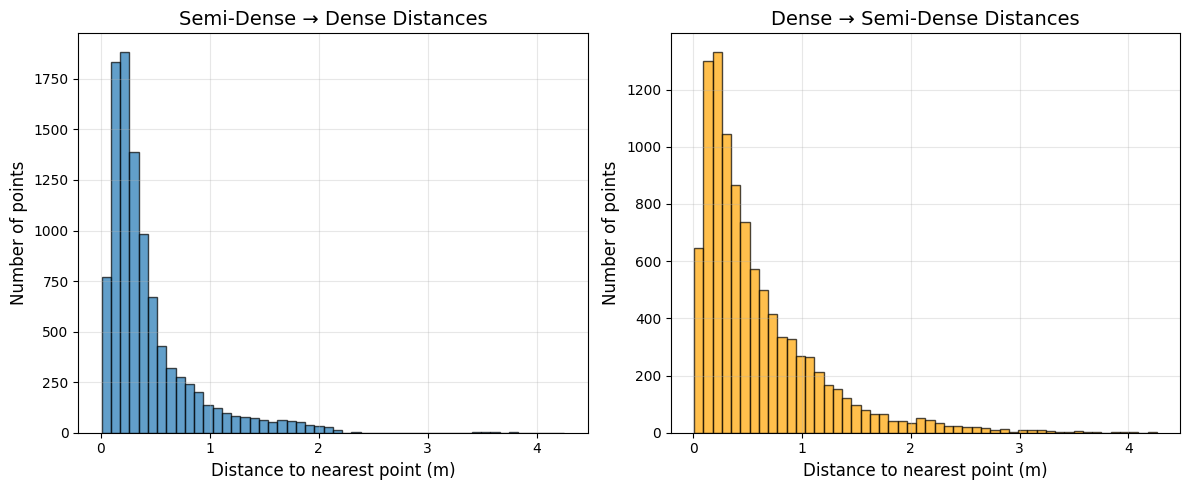

In [23]:
# Example: Compare semi-dense vs dense point clouds
print("Computing Chamfer distance between semi-dense and dense point clouds...\n")

# Subsample for computational efficiency
n_sample = 10000
pts_semidense = points[np.random.choice(len(points), min(n_sample, len(points)), replace=False)]
pts_dense = dense_points_fused[np.random.choice(len(dense_points_fused), min(n_sample, len(dense_points_fused)), replace=False)]

chamfer_dist, dists_sd_to_d, dists_d_to_sd = compute_chamfer(pts_semidense, pts_dense)

print(f"Chamfer Distance (Semi-dense ↔ Dense): {chamfer_dist:.4f} m")
print(f"\nBreakdown:")
print(f"  Semi-dense → Dense: {dists_sd_to_d.mean():.4f} m (mean), {dists_sd_to_d.max():.4f} m (max)")
print(f"  Dense → Semi-dense: {dists_d_to_sd.mean():.4f} m (mean), {dists_d_to_sd.max():.4f} m (max)")

# Visualize error distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(dists_sd_to_d, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Distance to nearest point (m)', fontsize=12)
plt.ylabel('Number of points', fontsize=12)
plt.title('Semi-Dense → Dense Distances', fontsize=14)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(dists_d_to_sd, bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Distance to nearest point (m)', fontsize=12)
plt.ylabel('Number of points', fontsize=12)
plt.title('Dense → Semi-Dense Distances', fontsize=14)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7.4 Iterative Point Cloud Construction

Simulate the **active reconstruction process** by incrementally building a point cloud from a limited set of views.

In [24]:
class IncrementalReconstruction:
    """
    Simulates iterative 3D reconstruction by accumulating point clouds from selected views.
    """
    def __init__(self, scene_path, camera_calib, trajectory):
        self.scene_path = scene_path
        self.camera_calib = camera_calib
        self.trajectory = trajectory
        self.accumulated_points = []
        self.selected_views = []

    def add_view(self, frame_idx, subsample=8):
        """Add a view to the reconstruction."""
        frame_id = str(frame_idx).zfill(7)

        # Load depth
        depth = np.array(Image.open(self.scene_path / "depth" / f"depth{frame_id}.png"))

        # Get pose
        T_world_device = self.trajectory['Ts_world_from_device'][frame_idx]

        # Convert to point cloud
        pts = depth_to_pointcloud(depth, self.camera_calib, T_world_device, subsample=subsample)

        self.accumulated_points.append(pts)
        self.selected_views.append(frame_idx)

        return len(pts)

    def get_current_pointcloud(self):
        """Get the current accumulated point cloud."""
        if not self.accumulated_points:
            return np.array([])
        return np.vstack(self.accumulated_points)

    def num_points(self):
        """Total number of points accumulated."""
        return len(self.get_current_pointcloud()) if self.accumulated_points else 0

    def reset(self):
        """Clear the reconstruction."""
        self.accumulated_points = []
        self.selected_views = []

# Initialize reconstruction
recon = IncrementalReconstruction(SCENE_PATH, camera_calib, trajectory)

print("IncrementalReconstruction class initialized")
print("\nUsage:")
print("  recon.add_view(frame_idx) - Add a view")
print("  recon.get_current_pointcloud() - Get accumulated PC")
print("  recon.num_points() - Get point count")
print("  recon.selected_views - List of added frame indices")

IncrementalReconstruction class initialized

Usage:
  recon.add_view(frame_idx) - Add a view
  recon.get_current_pointcloud() - Get accumulated PC
  recon.num_points() - Get point count
  recon.selected_views - List of added frame indices


In [25]:
# Simulate active reconstruction: add views incrementally
view_schedule = [0, 20, 40, 60, 80, 100, 120, 140]  # Selected views

print("Simulating incremental reconstruction...\n")

reconstruction_stats = []

for view_idx in view_schedule:
    n_new_pts = recon.add_view(view_idx, subsample=8)
    total_pts = recon.num_points()

    reconstruction_stats.append({
        'view': view_idx,
        'total_views': len(recon.selected_views),
        'new_points': n_new_pts,
        'total_points': total_pts
    })

    print(f"Added view {view_idx:3d}: +{n_new_pts:6,} pts → Total: {total_pts:7,} pts")

# Create dataframe
stats_df = pd.DataFrame(reconstruction_stats)

print(f"\n✓ Final reconstruction from {len(recon.selected_views)} views:")
print(f"  Total points: {recon.num_points():,}")
print(f"  Average points per view: {recon.num_points() / len(recon.selected_views):,.0f}")

Simulating incremental reconstruction...

Added view   0: + 6,121 pts → Total:   6,121 pts
Added view  20: + 6,121 pts → Total:  12,242 pts
Added view  40: + 6,121 pts → Total:  18,363 pts
Added view  60: + 6,121 pts → Total:  24,484 pts
Added view  80: + 6,121 pts → Total:  30,605 pts
Added view 100: + 6,121 pts → Total:  36,726 pts
Added view 120: + 6,121 pts → Total:  42,847 pts
Added view 140: + 6,121 pts → Total:  48,968 pts

✓ Final reconstruction from 8 views:
  Total points: 48,968
  Average points per view: 6,121
Added view 120: + 6,121 pts → Total:  42,847 pts
Added view 140: + 6,121 pts → Total:  48,968 pts

✓ Final reconstruction from 8 views:
  Total points: 48,968
  Average points per view: 6,121


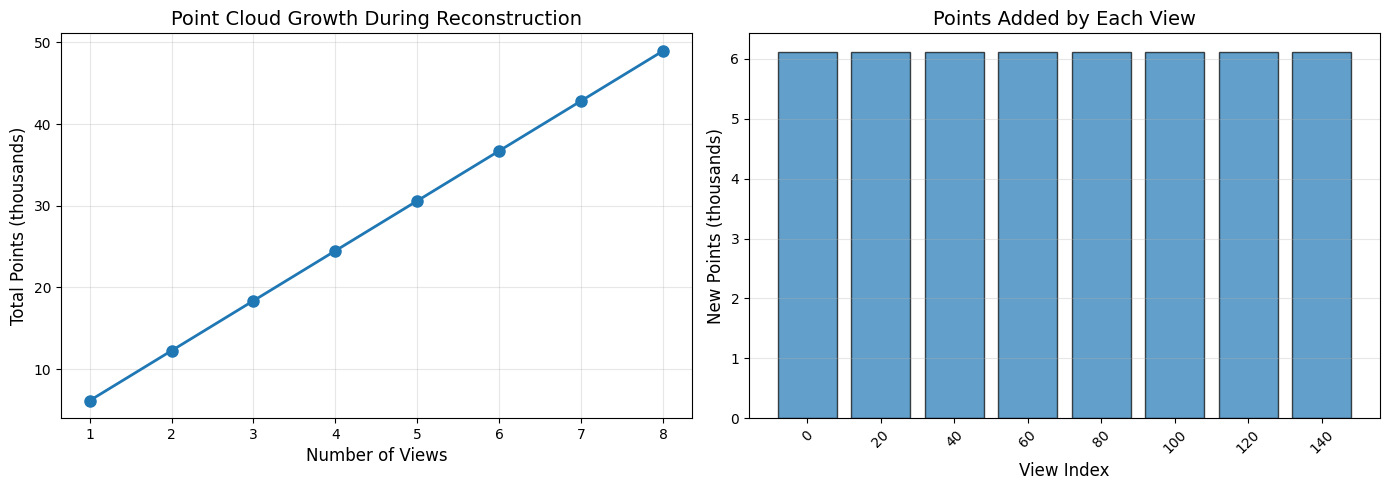

In [26]:
# Visualize reconstruction growth
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Point accumulation
axes[0].plot(stats_df['total_views'], stats_df['total_points'] / 1000, marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Views', fontsize=12)
axes[0].set_ylabel('Total Points (thousands)', fontsize=12)
axes[0].set_title('Point Cloud Growth During Reconstruction', fontsize=14)
axes[0].grid(alpha=0.3)

# Plot 2: Points per view
axes[1].bar(range(len(view_schedule)), stats_df['new_points'] / 1000, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('View Index', fontsize=12)
axes[1].set_ylabel('New Points (thousands)', fontsize=12)
axes[1].set_title('Points Added by Each View', fontsize=14)
axes[1].set_xticks(range(len(view_schedule)))
axes[1].set_xticklabels(view_schedule, rotation=45)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7.5 Reconstruction Quality vs Number of Views

Compare reconstruction quality (measured by Chamfer distance to GT) as we add more views.

In [27]:
# Reset and rebuild with quality tracking
recon.reset()

# Define GT reference (use dense fused PC or semi-dense)
gt_reference = points  # Use semi-dense as GT
n_gt_sample = 5000
gt_sampled = gt_reference[np.random.choice(len(gt_reference), min(n_gt_sample, len(gt_reference)), replace=False)]

quality_stats = []

print("Building reconstruction and tracking Chamfer distance...\n")

for i, view_idx in enumerate(view_schedule):
    recon.add_view(view_idx, subsample=8)
    current_pc = recon.get_current_pointcloud()

    # Subsample for Chamfer computation
    n_recon_sample = min(5000, len(current_pc))
    recon_sampled = current_pc[np.random.choice(len(current_pc), n_recon_sample, replace=False)]

    # Compute Chamfer distance to GT
    chamfer, _, _ = compute_chamfer(recon_sampled, gt_sampled)

    quality_stats.append({
        'num_views': i + 1,
        'view_idx': view_idx,
        'total_points': len(current_pc),
        'chamfer_dist': chamfer
    })

    print(f"Views: {i+1:2d} | Frame {view_idx:3d} | Points: {len(current_pc):7,} | Chamfer: {chamfer:.4f} m")

quality_df = pd.DataFrame(quality_stats)

print("\n✓ Reconstruction quality analysis complete")

Building reconstruction and tracking Chamfer distance...

Views:  1 | Frame   0 | Points:   6,121 | Chamfer: 2.5431 m
Views:  2 | Frame  20 | Points:  12,242 | Chamfer: 2.2597 m
Views:  3 | Frame  40 | Points:  18,363 | Chamfer: 1.7099 m
Views:  4 | Frame  60 | Points:  24,484 | Chamfer: 1.4620 m
Views:  5 | Frame  80 | Points:  30,605 | Chamfer: 1.3533 m
Views:  6 | Frame 100 | Points:  36,726 | Chamfer: 1.2732 m
Views:  7 | Frame 120 | Points:  42,847 | Chamfer: 1.3100 m
Views:  8 | Frame 140 | Points:  48,968 | Chamfer: 1.3069 m

✓ Reconstruction quality analysis complete
Views:  6 | Frame 100 | Points:  36,726 | Chamfer: 1.2732 m
Views:  7 | Frame 120 | Points:  42,847 | Chamfer: 1.3100 m
Views:  8 | Frame 140 | Points:  48,968 | Chamfer: 1.3069 m

✓ Reconstruction quality analysis complete


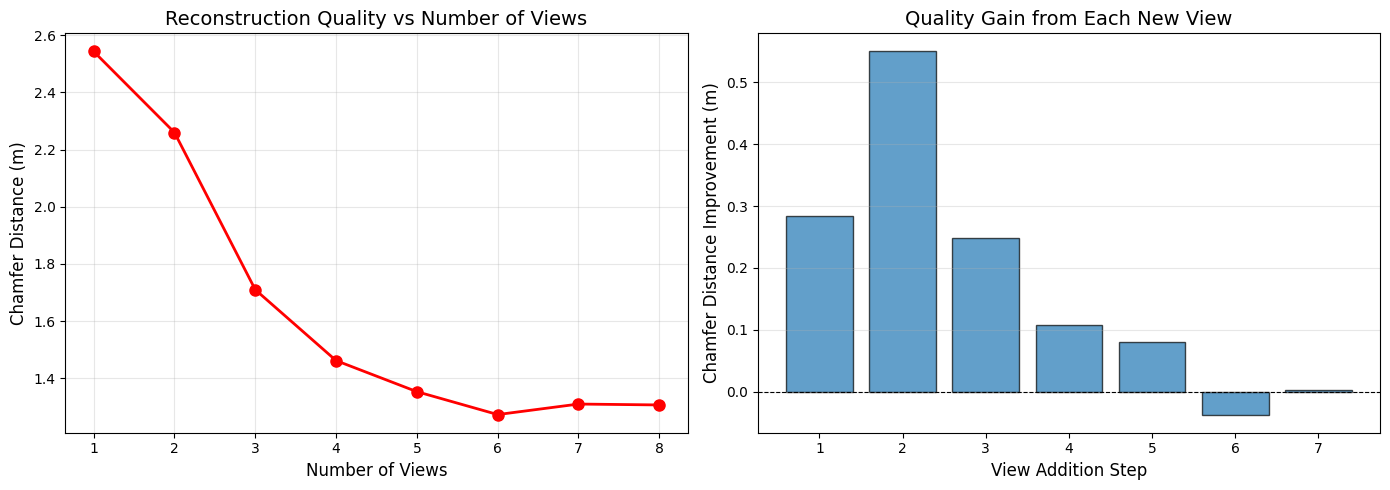


Key insights:
  Initial Chamfer (1 view): 2.5431 m
  Final Chamfer (8 views): 1.3069 m
  Total improvement: 48.6%


In [28]:
# Plot reconstruction quality vs views
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Chamfer distance decreases with more views
axes[0].plot(quality_df['num_views'], quality_df['chamfer_dist'], marker='o', linewidth=2, markersize=8, color='red')
axes[0].set_xlabel('Number of Views', fontsize=12)
axes[0].set_ylabel('Chamfer Distance (m)', fontsize=12)
axes[0].set_title('Reconstruction Quality vs Number of Views', fontsize=14)
axes[0].grid(alpha=0.3)

# Plot 2: Quality improvement rate (derivative)
chamfer_improvement = np.diff(quality_df['chamfer_dist'])
axes[1].bar(range(1, len(chamfer_improvement)+1), -chamfer_improvement, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('View Addition Step', fontsize=12)
axes[1].set_ylabel('Chamfer Distance Improvement (m)', fontsize=12)
axes[1].set_title('Quality Gain from Each New View', fontsize=14)
axes[1].axhline(0, color='black', linewidth=0.8, linestyle='--')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nKey insights:")
print(f"  Initial Chamfer (1 view): {quality_df['chamfer_dist'].iloc[0]:.4f} m")
print(f"  Final Chamfer ({len(view_schedule)} views): {quality_df['chamfer_dist'].iloc[-1]:.4f} m")
print(f"  Total improvement: {100*(quality_df['chamfer_dist'].iloc[0] - quality_df['chamfer_dist'].iloc[-1])/quality_df['chamfer_dist'].iloc[0]:.1f}%")

## Implications for NBV Planning

### Key Insights:

1. **Entity-Aware RRI**: SceneScript entities provide structured targets for reconstruction quality metrics
2. **Point Visibility**: Observation data shows which regions have good/poor coverage
3. **Coordinate Transforms**: Essential for computing viewpoint utility and projecting candidate views
4. **Instance Segmentation**: Enables object-level reconstruction quality assessment
5. **Incremental Reconstruction**: We can simulate active reconstruction by adding views iteratively
6. **Quality Metrics**: Chamfer distance quantifies reconstruction completeness vs GT

### Challenge for ASE:
- **Single Trajectory**: Each scene has only one egocentric path
- **No Novel Views**: Cannot query arbitrary viewpoints directly

### Proposed Solutions:
1. **Gaussian Splatting**: Train 3DGS on trajectory+depth → render novel views
2. **Entity-Level Metrics**: Use SceneScript entities directly for RRI without dense rendering
3. **Coverage Analysis**: Use point visibility from observations data
4. **Depth-Based GT**: Fuse depth maps to create dense GT point clouds
5. **Iterative Simulation**: Use incremental reconstruction to test NBV strategies

# Summary: Most Relevant ProjectAria Tools & Libraries

## Essential Functions from `projectaria_tools`:

### ASE Dataset (`projectaria_tools.projects.ase`):
- `readers.read_language_file()` - Load SceneScript ground truth
- `readers.read_trajectory_file()` - Load 6DoF camera poses
- `readers.read_points_file()` - Load semi-dense point cloud
- `interpreter.language_to_bboxes()` - Convert entities to 3D boxes
- `ase.get_ase_rgb_calibration()` - Get camera intrinsics

### MPS Data (`projectaria_tools.core.mps`):
- `mps.read_global_point_cloud()` - Load point cloud with confidence
- `mps.utils.filter_points_from_confidence()` - Filter by uncertainty

### Coordinate Transforms (`projectaria_tools.core.sophus`):
- `SE3.from_quat_and_translation()` - Build transform from pose
- `SE3.to_matrix()` - Convert to 4x4 matrix

### Camera Calibration:
- `camera.project()` - Project 3D point to image
- `camera.unproject()` - Unproject pixel to 3D ray
- `camera.get_focal_lengths()` - Get focal length
- `camera.get_transform_device_camera()` - Device-to-camera transform

## Additional Libraries for Point Cloud Operations:

### Open3D (Recommended):
- **Install**: `pip install open3d`
- `o3d.geometry.PointCloud()` - Point cloud data structure
- `pcd.compute_point_cloud_distance()` - Nearest neighbor distances (fast)
- `o3d.visualization.draw_geometries()` - Interactive 3D visualization
- `o3d.io.write_point_cloud()` - Save to PLY/PCD format

### Alternative: SciPy:
- `scipy.spatial.KDTree()` - Nearest neighbor search (slower but no extra deps)
- `scipy.spatial.distance.cdist()` - Pairwise distances

## Point Cloud File Formats:

### `semidense_points.csv.gz`:
- Contains 3D world coordinates + uncertainty metrics
- Columns: uid, graph_uid, px_world, py_world, pz_world, inv_dist_std, dist_std
- Represents SLAM-reconstructed sparse/semi-dense structure

### `semidense_observations.csv.gz`:
- Contains point visibility information
- Columns: point_uid, frame_tracking_timestamp_us, camera_serial, u, v
- Maps which 3D points were observed in which frames at which pixels

# Quick Reference: Key Workflows

## 1. Load Semi-Dense Point Cloud
```python
points_df = pd.read_csv("semidense_points.csv.gz", compression='gzip')
points = points_df[['px_world', 'py_world', 'pz_world']].values
```

## 2. Load Observations (Visibility Data)
```python
obs_df = pd.read_csv("semidense_observations.csv.gz", compression='gzip')
obs_per_point = obs_df.groupby('uid').size()  # How many frames see each point
```

## 3. Convert Depth Image to Point Cloud
```python
pts_world = depth_to_pointcloud(depth, camera_calib, T_world_from_device, subsample=4)
```

## 4. Compute Chamfer Distance
```python
chamfer_dist, dists_1to2, dists_2to1 = compute_chamfer(pc1, pc2)
```

## 5. Incremental Reconstruction
```python
recon = IncrementalReconstruction(scene_path, camera_calib, trajectory)
recon.add_view(frame_idx)
current_pc = recon.get_current_pointcloud()
```

## 6. Compare Reconstruction Quality
```python
# After adding views iteratively
chamfer = compute_chamfer(recon.get_current_pointcloud(), gt_pointcloud)
```